<a href="https://colab.research.google.com/github/zakyzuf/2141720173-machine-learning-2023/blob/main/Pertemuan%2010-Recurrent%20Neural%20Network%20(RNN)/JS10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Praktikum 1: RNN untuk Analisis Sentimen

### Setup

In [4]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [5]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
 plt.plot(history.history[metric])
 plt.plot(history.history['val_'+metric], '')
 plt.xlabel("Epochs")
 plt.ylabel(metric)
 plt.legend([metric, 'val_'+metric])

### Setup input pipeline

#### Download Dataset

In [6]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [7]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


#### Acak data untuk pelatihan dan membuat kumpulan pasangan (teks, label)

In [8]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'Peter O\'Toole is a treat to watch in roles where the lines he speaks are good and offer a chance for him to swagger in drunken stupor. The lovely Susannah York provides a good foil for O\'Toole\'s dramatic presence.<br /><br />The film alludes to incest--without a single explicit scene--but it is able to entertain the viewer in its raucous social commentary. Though this is not major film by any reckoning, it will be remembered for its entertaining performances. <br /><br />Even York, signing the papers at the end, is a treat to watch, exuding tragedy silently. The possible weakness here is Thompson\'s laid-back direction. But the film floats because of the actors and the script.<br /><br />I saw the film twice over a period of 20 years--on both occasions with the name "Brotherly love". "Country dance" is a rather farcical and inappropriate title for this movie, wherever it was released as such.'
 b'The original movie, The Odd Couple, has some wonderful comic one-liners. The

### Buat Teks Encoder

In [9]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [10]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [11]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[792,   1,   7, ...,   0,   0,   0],
       [  2, 198,  18, ...,   0,   0,   0],
       [ 34,   1, 246, ...,   0,   0,   0]])

In [12]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'Peter O\'Toole is a treat to watch in roles where the lines he speaks are good and offer a chance for him to swagger in drunken stupor. The lovely Susannah York provides a good foil for O\'Toole\'s dramatic presence.<br /><br />The film alludes to incest--without a single explicit scene--but it is able to entertain the viewer in its raucous social commentary. Though this is not major film by any reckoning, it will be remembered for its entertaining performances. <br /><br />Even York, signing the papers at the end, is a treat to watch, exuding tragedy silently. The possible weakness here is Thompson\'s laid-back direction. But the film floats because of the actors and the script.<br /><br />I saw the film twice over a period of 20 years--on both occasions with the name "Brotherly love". "Country dance" is a rather farcical and inappropriate title for this movie, wherever it was released as such.'
Round-trip:  peter [UNK] is a [UNK] to watch in roles where the lines he [UNK

### Buat Model

In [13]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

#### Lapisan penyematan menggunakan masking (uses masking ) untuk menangani panjang urutan yang bervariasi.

In [14]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


#### Evaluasi pertama

In [15]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 7s 7s/step
[0.00031315]


#### Evaluasi kedua

In [16]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 60ms/step
[0.00031315]


#### Compile model Keras

In [17]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

### Train Model

In [18]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 49s 100ms/step - loss: 0.6409 - accuracy: 0.5608 - val_loss: 0.4872 - val_accuracy: 0.7536
Epoch 2/10
391/391 [==============================] - 26s 65ms/step - loss: 0.4010 - accuracy: 0.8145 - val_loss: 0.3639 - val_accuracy: 0.8359
Epoch 3/10
391/391 [==============================] - 25s 64ms/step - loss: 0.3374 - accuracy: 0.8516 - val_loss: 0.3366 - val_accuracy: 0.8547
Epoch 4/10
391/391 [==============================] - 24s 61ms/step - loss: 0.3155 - accuracy: 0.8635 - val_loss: 0.3301 - val_accuracy: 0.8583
Epoch 5/10
391/391 [==============================] - 24s 61ms/step - loss: 0.3099 - accuracy: 0.8656 - val_loss: 0.3260 - val_accuracy: 0.8651
Epoch 6/10
391/391 [==============================] - 25s 63ms/step - loss: 0.3045 - accuracy: 0.8676 - val_loss: 0.3192 - val_accuracy: 0.8552
Epoch 7/10
391/391 [==============================] - 25s 63ms/step - loss: 0.3021 - accuracy: 0.8696 - val_loss: 0.3182 - val_accuracy

In [19]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 11s 29ms/step - loss: 0.3253 - accuracy: 0.8434
Test Loss: 0.3253357708454132
Test Accuracy: 0.8433600068092346


(0.0, 0.6580631628632545)

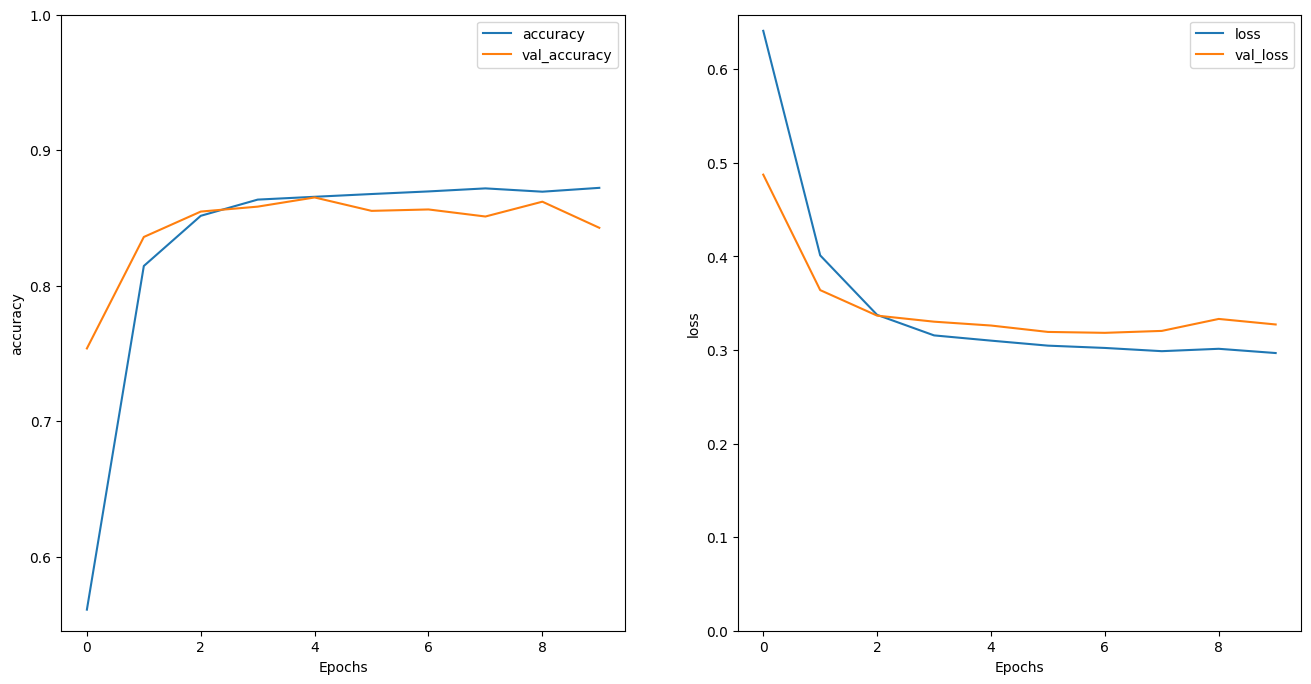

In [20]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [21]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 2s 2s/step


### Stack two or more LSTM layers

In [22]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [23]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [24]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 76s 149ms/step - loss: 0.6131 - accuracy: 0.6034 - val_loss: 0.4246 - val_accuracy: 0.8036
Epoch 2/10
391/391 [==============================] - 46s 117ms/step - loss: 0.3808 - accuracy: 0.8359 - val_loss: 0.3500 - val_accuracy: 0.8568
Epoch 3/10
391/391 [==============================] - 46s 118ms/step - loss: 0.3408 - accuracy: 0.8566 - val_loss: 0.3428 - val_accuracy: 0.8615
Epoch 4/10
391/391 [==============================] - 45s 115ms/step - loss: 0.3212 - accuracy: 0.8638 - val_loss: 0.3278 - val_accuracy: 0.8552
Epoch 5/10
391/391 [==============================] - 44s 113ms/step - loss: 0.3115 - accuracy: 0.8666 - val_loss: 0.3318 - val_accuracy: 0.8401
Epoch 6/10
391/391 [==============================] - 45s 116ms/step - loss: 0.3068 - accuracy: 0.8698 - val_loss: 0.3217 - val_accuracy: 0.8599
Epoch 7/10
391/391 [==============================] - 45s 114ms/step - loss: 0.3019 - accuracy: 0.8705 - val_loss: 0.3226 - val_ac

In [25]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 18s 47ms/step - loss: 0.3213 - accuracy: 0.8458
Test Loss: 0.32126539945602417
Test Accuracy: 0.8457599878311157


In [26]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
              'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 6s 6s/step
[[-1.7685101]]


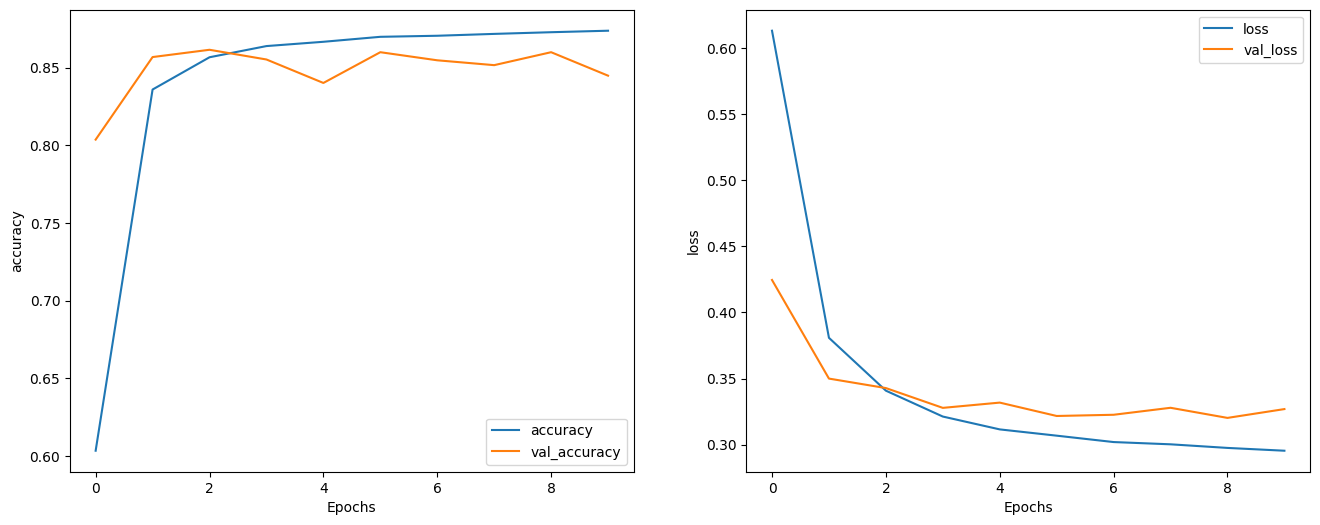

In [27]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

# Praktikum 2: Generator Teks dengan RNN

### Setup

#### Import TensorFlow

In [28]:
import tensorflow as tf
import numpy as np
import os
import time

#### Download Dataset Shakespeare

In [29]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1115394/1115394 [==============================] - 0s 0us/step


#### Load Data

In [30]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [31]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [32]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


### Olah Teks

#### Vectorize Teks

In [33]:
example_texts = ['abcdefg', 'xyz']
chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [34]:
ids_from_chars = tf.keras.layers.StringLookup(
vocabulary=list(vocab), mask_token=None)

In [35]:
ids = ids_from_chars(chars)
ids

<tf.RaggedTensor [[40, 41, 42, 43, 44, 45, 46], [63, 64, 65]]>

In [36]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

In [37]:
chars = chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [38]:
tf.strings.reduce_join(chars, axis=-1).numpy()

array([b'abcdefg', b'xyz'], dtype=object)

In [39]:
def text_from_ids(ids):
    return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

#### Prediksi
#### Membuat Trianing Set dan Target

In [40]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [41]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [42]:
for ids in ids_dataset.take(10):
     print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [43]:
seq_length = 100

In [44]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


In [45]:
for seq in sequences.take(5):
    print(text_from_ids(seq).numpy())

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


In [46]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [47]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [48]:
dataset = sequences.map(split_input_target)

In [49]:
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


#### Membuat Batch Training

In [50]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

### Buat Model

In [51]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [52]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [53]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

### Uji Model

In [54]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 66) # (batch_size, sequence_length, vocab_size)


In [55]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     multiple                  16896     
                                                                 
 gru (GRU)                   multiple                  3938304   
                                                                 
 dense_4 (Dense)             multiple                  67650     
                                                                 
Total params: 4022850 (15.35 MB)
Trainable params: 4022850 (15.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [56]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

In [57]:
sampled_indices

array([59,  5,  9, 48, 34, 56, 16, 14, 42, 64, 60, 64, 43,  7, 15, 64, 60,
       25, 24, 51, 13,  6, 62, 41, 55, 17, 40, 63, 62, 26, 54, 32, 31,  7,
       48, 17, 51, 38, 25, 41, 65,  3,  3, 61, 37, 48, 55, 39, 20,  3,  7,
       44, 46, 65, 62, 53, 46, 11, 24, 57, 64, 22, 37,  7, 37, 49, 36, 64,
       31, 13, 24, 29,  3,  4, 12,  0, 58, 10, 19, 51, 60, 27, 50, 50, 29,
       65, 29, 14, 29, 33, 21, 56, 28, 34, 53, 60, 59, 28,  0, 24])

In [58]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b', a virgin-violator;\nIs it not strange and strange?\n\nDUKE VINCENTIO:\nNay, it is ten times strange.\n\n'

Next Char Predictions:
 b"t&.iUqCAcyuyd,ByuLKl?'wbpDaxwMoSR,iDlYLbz!!vXipZG!,egzwng:KryIX,XjWyR?KP!$;[UNK]s3FluNkkPzPAPTHqOUnutO[UNK]K"


### Train Model

#### Tambahan optimizer dan fungsi loss

In [59]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [60]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 66)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.189362, shape=(), dtype=float32)


In [61]:
tf.exp(example_batch_mean_loss).numpy()

65.98068

In [62]:
model.compile(optimizer='adam', loss=loss)

#### Konfigurasi Checkpoints

In [63]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

#### Lakukan Proses Training

In [64]:
history = model.fit(dataset, epochs=10, callbacks=[checkpoint_callback])

Epoch 1/10
172/172 [==============================] - 15s 63ms/step - loss: 2.6932
Epoch 2/10
172/172 [==============================] - 13s 62ms/step - loss: 1.9744
Epoch 3/10
172/172 [==============================] - 12s 60ms/step - loss: 1.7002
Epoch 4/10
172/172 [==============================] - 11s 57ms/step - loss: 1.5421
Epoch 5/10
172/172 [==============================] - 11s 58ms/step - loss: 1.4454
Epoch 6/10
172/172 [==============================] - 12s 60ms/step - loss: 1.3787
Epoch 7/10
172/172 [==============================] - 12s 61ms/step - loss: 1.3269
Epoch 8/10
172/172 [==============================] - 12s 60ms/step - loss: 1.2829
Epoch 9/10
172/172 [==============================] - 12s 59ms/step - loss: 1.2420
Epoch 10/10
172/172 [==============================] - 12s 58ms/step - loss: 1.2030


### Generate Teks

In [65]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [66]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

In [67]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

ROMEO:
Let them then.

CLARENCE:
A bride and the remain a diefif you never live.

JLUTUS:
I must let not have heard going his rather
In their hearts. Come forefull, bedincein'd,
She are bleeding in his people.

SICINIUS:
Let us boats the rash: therefore Clooker Edward,
He shuning these I not in Angelo,
Who both beftard her beats do now?

Second Servant:
Virtue, let him by crown'd sleep not good.

MENENIUS:
Where is thy death?
What sadest thy grace equal i' the starp, thou, spirits
Vincedit'st thou hast my brother best;
A fair as once he sees him: and here knew
The raresty hate the movery; one kiss hust
For his rot unhapen thy study, and not out,
Which by extegh on thy mask, spend it: put
of hope is mine own good Master
For our nother struck a lady; a worde to quietly his
neck yet that happy disgured was rather than your Honora?

POMPMIEY:
But my country's goed,
A noble house! Here so, to Clarence daughter, signior
But sees now. Think you whom he hath sever'd me and that
expectly reveng

In [68]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

tf.Tensor(
[b"ROMEO:\nWhat news! what's the sway, all gone and hold\nThe absebularrow sentence and pluck flowers.\n\nJULIET:\nHere commander?\nWhy holy honour not be slip, he masted with the wind\nLeft I may leap you my body suddenle:\nSee you with what the last was he:\nHe'll stay me now. what 'twas bade to kind of hop?\n\nCURTIS:\nI tell your husband,\nAnother bearsh to the rides; there it up sir,\nAh it better your goodmes that beguiler, the way\nTo pray 'I will joy. Farewell; for westative hours have more belong\ntheir home of length's and a mowning thrice Heart me.\n\nKING EDWARD IV:\nBring ready, blistering the hand and--O Waking! why, though it prosperets\nHe hast that hath broke fair mad most like a little believio.\nBut you thank you? Thy followers there:\nThy unkind and piteous crimorrus or consent did I receed\nThe roof that called for subjects, let have goodness\nIn your kind of Mancas by thy news from save,\nTell me alone. What says he speak not to the place.\n\nELBOD:\nHe

### Ekspor Model Generator

In [69]:
tf.saved_model.save(one_step_model, 'one_step')
one_step_reloaded = tf.saved_model.load('one_step')

In [70]:
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(100):
  next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
  result.append(next_char)

print(tf.strings.join(result)[0].numpy().decode("utf-8"))

ROMEO:
It is gone, tell me, have at thy mother, to the state.
But now, sid may obsequies will not fail is 


# Tugas Praktikum

1. Jalankan Model dan hitung loss dengan `tf.GradientTape`.
2. Hitung update dan terapkan pada model dengan optimizer


In [71]:
class CustomTraining(MyModel):
  @tf.function
  def train_step(self, inputs):
      inputs, labels = inputs
      with tf.GradientTape() as tape:
          predictions = self(inputs, training=True)
          loss = self.loss(labels, predictions)
      grads = tape.gradient(loss, model.trainable_variables)
      self.optimizer.apply_gradients(zip(grads, model.trainable_variables))

      return {'loss': loss}

In [72]:
model = CustomTraining(
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [73]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [74]:
model.fit(dataset, epochs=1)

172/172 [==============================] - 15s 61ms/step - loss: 2.7259


In [75]:
EPOCHS = 10

mean = tf.metrics.Mean()

for epoch in range(EPOCHS):
    start = time.time()

    mean.reset_states()
    for (batch_n, (inp, target)) in enumerate(dataset):
        logs = model.train_step([inp, target])
        mean.update_state(logs['loss'])

        if batch_n % 50 == 0:
            template = f"Epoch {epoch+1} Batch {batch_n} Loss {logs['loss']:.4f}"
            print(template)

    # saving (checkpoint) the model every 5 epochs
    if (epoch + 1) % 5 == 0:
        model.save_weights(checkpoint_prefix.format(epoch=epoch))

    print()
    print(f'Epoch {epoch+1} Loss: {mean.result().numpy():.4f}')
    print(f'Time taken for 1 epoch {time.time() - start:.2f} sec')
    print("_"*80)

model.save_weights(checkpoint_prefix.format(epoch=epoch))

Epoch 1 Batch 0 Loss 2.1581
Epoch 1 Batch 50 Loss 2.0693
Epoch 1 Batch 100 Loss 1.9772
Epoch 1 Batch 150 Loss 1.8845

Epoch 1 Loss: 1.9888
Time taken for 1 epoch 13.06 sec
________________________________________________________________________________
Epoch 2 Batch 0 Loss 1.8599
Epoch 2 Batch 50 Loss 1.7751
Epoch 2 Batch 100 Loss 1.6376
Epoch 2 Batch 150 Loss 1.7035

Epoch 2 Loss: 1.7100
Time taken for 1 epoch 12.00 sec
________________________________________________________________________________
Epoch 3 Batch 0 Loss 1.5545
Epoch 3 Batch 50 Loss 1.5741
Epoch 3 Batch 100 Loss 1.5547
Epoch 3 Batch 150 Loss 1.5024

Epoch 3 Loss: 1.5503
Time taken for 1 epoch 11.84 sec
________________________________________________________________________________
Epoch 4 Batch 0 Loss 1.4770
Epoch 4 Batch 50 Loss 1.4626
Epoch 4 Batch 100 Loss 1.4683
Epoch 4 Batch 150 Loss 1.4051

Epoch 4 Loss: 1.4519
Time taken for 1 epoch 11.39 sec
_____________________________________________________________________

Apa perbedaanya dengan praktikum 2?

Metode pelatihan pada praktikum 2, menggunakan metode pelatihan OneStep, merujuk pada pendekatan pelatihan yang sederhana di mana model dilatih menggunakan keseluruhan dataset sekaligus. Model ini menerima urutan data masukan dan menghasilkan urutan prediksi berdasarkan urutan masukan tersebut.

Sedangkan kode di atas menggunakan pelatihan kustom, pada RNN pelatihan custom adalah pendekatan yang lebih kompleks di mana kita memiliki kontrol lebih besar atas proses pelatihan. Hal ini memungkinkan kita untuk menyesuaikan berbagai parameter dan komponen dari RNN, seperti arsitektur jaringan, fungsi aktivasi, jenis optimisasi, dan lain sebagainya.